In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [7]:
# %% Set up the Basics

ticker = 'AMZN'
lvl = 10

name_book = 'AAPL_2012-06-21_34200000_57600000_orderbook_10.csv'
name_mess = 'AAPL_2012-06-21_34200000_57600000_message_10.csv' 

demo_date = pd.Timestamp('2012-06-21')

In [8]:
# %% Load Message File

mess = np.loadtxt(name_mess, delimiter=',')

In [9]:
# %% Data Preparation - Message File

start_trad = 9.5 * 60 * 60  # 9:30 AM in seconds
end_trad = 16 * 60 * 60     # 4:00 PM in seconds

# Keep only within trading hours
time_idx = (mess[:, 0] >= start_trad) & (mess[:, 0] <= end_trad)
mess = mess[time_idx]

# Check for trading halts
trade_halt_idx = np.where(mess[:, 1] == 7)[0]

if trade_halt_idx.size > 0:
    print("Data contains trading halt!")
else:
    print("No trading halts detected.")

No trading halts detected.


In [10]:
# %% Set Bounds for Intraday Intervals

freq = 5 * 60  # 5 minutes in seconds
bounds = np.arange(start_trad, end_trad + freq, freq)

bl = len(bounds)
bound_idx = np.zeros(bl, dtype=int)

k1 = 0
for k2 in range(mess.shape[0]):
    if k1 < bl and mess[k2, 0] >= bounds[k1]:
        bound_idx[k1] = k2
        k1 += 1

bound_idx[:-1] -= 1
bound_idx[-1] = len(mess) - 1

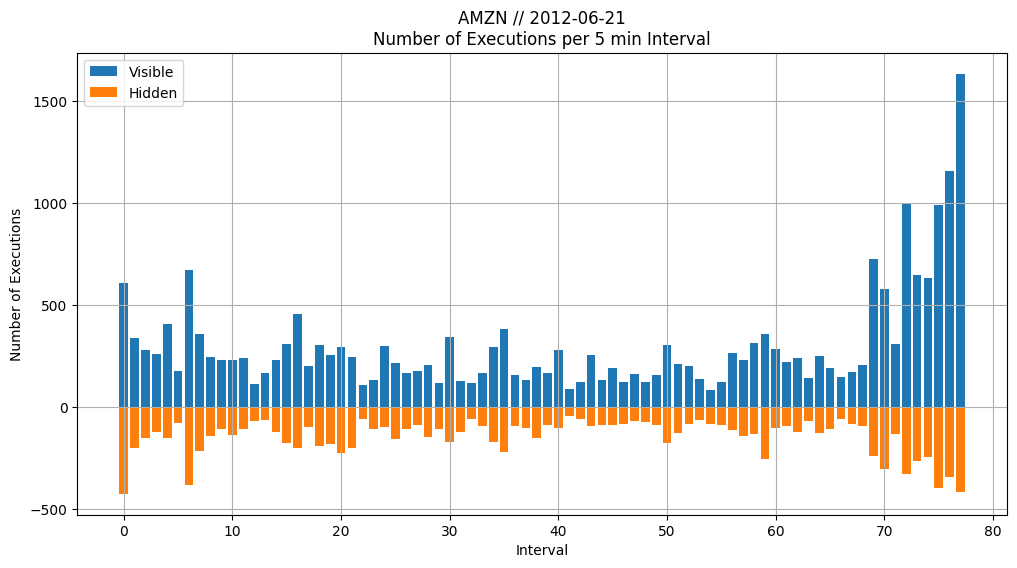

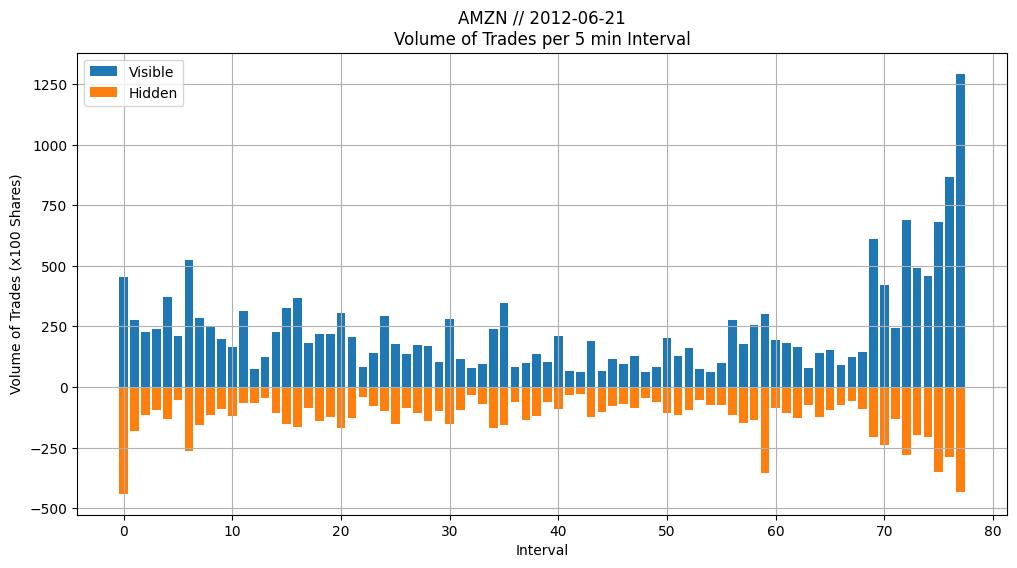

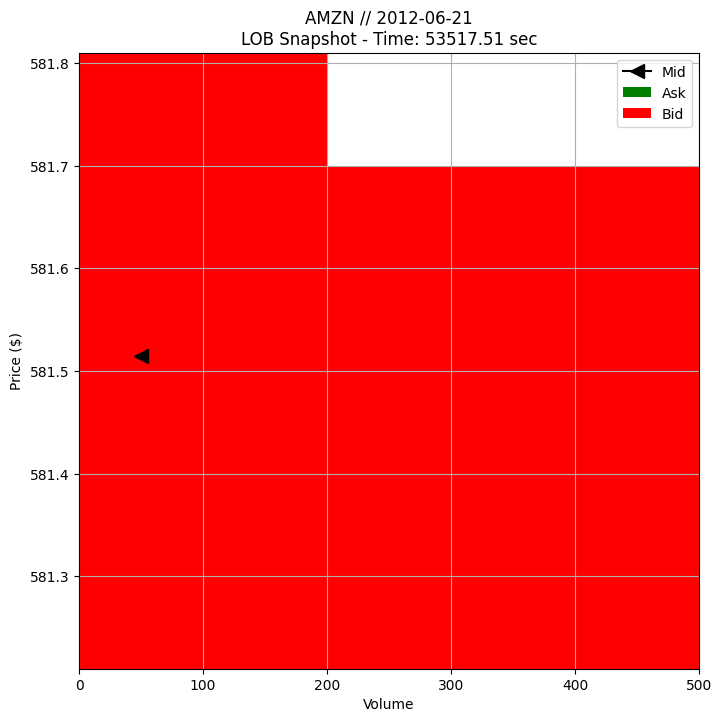

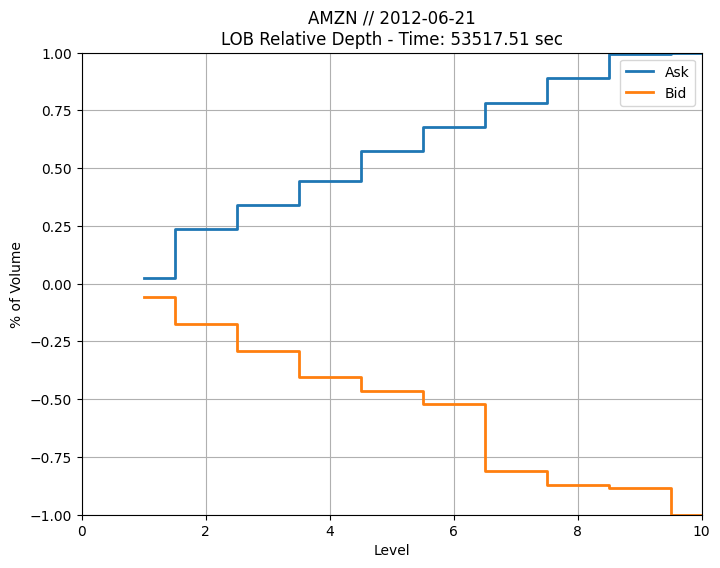

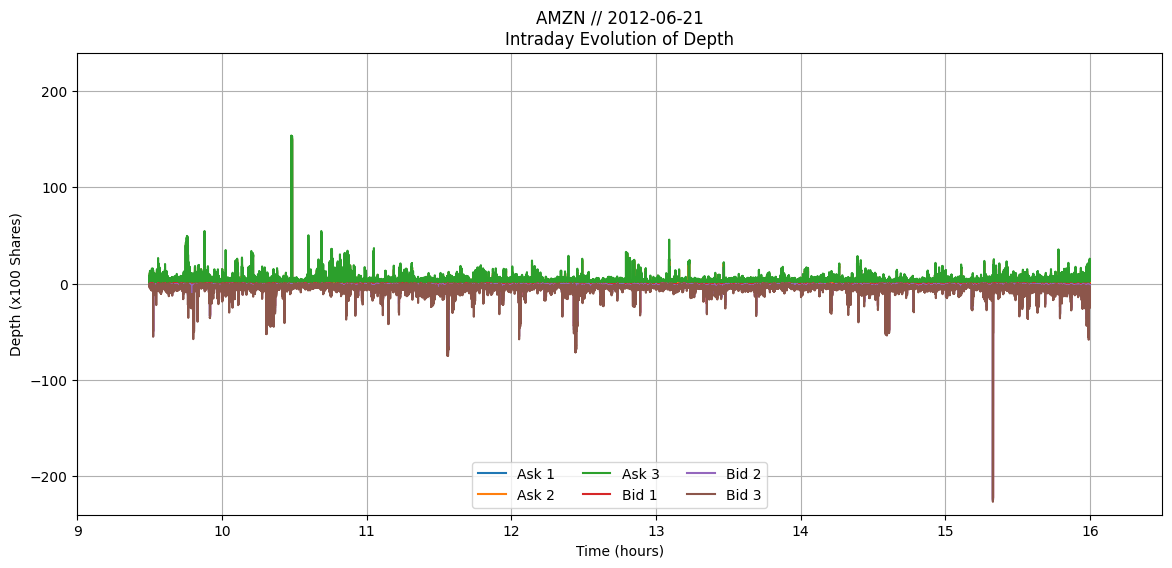

In [11]:
# %% Plot - Number of Executions and Trade Volume by Interval

trades_info = np.zeros((bl-1, 4))

for k1 in range(bl-1):
    temp = mess[bound_idx[k1]+1:bound_idx[k1+1]+1, [1, 3]]
    
    temp_vis = temp[temp[:, 0] == 4, 1]
    temp_hid = temp[temp[:, 0] == 5, 1]

    trades_info[k1, :] = [len(temp_vis), temp_vis.sum(), len(temp_hid), temp_hid.sum()]

# Number of Executions
plt.figure(figsize=(12,6))
plt.bar(np.arange(bl-1), trades_info[:,0], label='Visible')
plt.bar(np.arange(bl-1), -trades_info[:,2], label='Hidden')
plt.title(f"{ticker} // {demo_date.date()}\nNumber of Executions per {freq//60} min Interval")
plt.xlabel("Interval")
plt.ylabel("Number of Executions")
plt.legend()
plt.grid(True)
plt.show()

# Volume of Trades
plt.figure(figsize=(12,6))
plt.bar(np.arange(bl-1), trades_info[:,1]/100, label='Visible')
plt.bar(np.arange(bl-1), -trades_info[:,3]/100, label='Hidden')
plt.title(f"{ticker} // {demo_date.date()}\nVolume of Trades per {freq//60} min Interval")
plt.xlabel("Interval")
plt.ylabel("Volume of Trades (x100 Shares)")
plt.legend()
plt.grid(True)
plt.show()

# %% Load Orderbook File

book = np.loadtxt(name_book, delimiter=',')

# %% Data Preparation - Orderbook File

book = book[time_idx]

# Convert prices to dollars
book[:, np.arange(0, 4*lvl, 2)] /= 10000

# %% Plot - Snapshot of the Limit Order Book

event_idx = random.randint(0, len(book)-1)

ask_price_pos = np.arange(0, 4*lvl, 4)
ask_vol_pos = ask_price_pos + 1
bid_price_pos = ask_price_pos + 2
bid_vol_pos = bid_price_pos + 1
vol_pos = np.arange(1, 4*lvl, 2)

max_price = book[event_idx, ask_price_pos[-1]] + 0.01
min_price = book[event_idx, bid_price_pos[-1]] - 0.01
max_vol = book[event_idx, vol_pos].max()

mid = 0.5 * (book[event_idx, 0] + book[event_idx, 2])

plt.figure(figsize=(8,8))
plt.barh(book[event_idx, ask_price_pos], book[event_idx, ask_vol_pos], color='green', label='Ask')
plt.barh(book[event_idx, bid_price_pos], book[event_idx, bid_vol_pos], color='red', label='Bid')
plt.plot([50], [mid], marker='<', color='black', markersize=10, label='Mid')
plt.xlim(0, max_vol)
plt.ylim(min_price, max_price)
plt.title(f"{ticker} // {demo_date.date()}\nLOB Snapshot - Time: {mess[event_idx,0]:.2f} sec")
plt.xlabel('Volume')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# %% Plot - Relative Depth in the Limit Order Book

book_vol_ask = np.cumsum(book[event_idx, ask_vol_pos])
book_vol_bid = np.cumsum(book[event_idx, bid_vol_pos])

book_vol_ask /= book_vol_ask[-1]
book_vol_bid /= book_vol_bid[-1]

plt.figure(figsize=(8,6))
plt.step(range(1, lvl+1), book_vol_ask, where='mid', label='Ask', linewidth=2)
plt.step(range(1, lvl+1), -book_vol_bid, where='mid', label='Bid', linewidth=2)
plt.title(f"{ticker} // {demo_date.date()}\nLOB Relative Depth - Time: {mess[event_idx,0]:.2f} sec")
plt.xlabel('Level')
plt.ylabel('% of Volume')
plt.xlim(0, lvl)
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

# %% Plot - Intraday Evolution of Depth

max_lvl = 3

ask_vol_pos = np.arange(1, max_lvl*4, 4)
book_vol_ask = np.cumsum(book[:, ask_vol_pos]/100, axis=1)
book_vol_bid = np.cumsum(book[:, ask_vol_pos+2]/100, axis=1)

max_vol = max(np.max(book_vol_ask[:,-1]), np.max(book_vol_bid[:,-1]))
max_vol = np.floor(max_vol*1.1/10)*10

legend_str = [f'Ask {i+1}' for i in range(max_lvl)] + [f'Bid {i+1}' for i in range(max_lvl)]

plt.figure(figsize=(14,6))
plt.plot(mess[:,0]/3600, np.hstack((book_vol_ask, -book_vol_bid)))
plt.title(f"{ticker} // {demo_date.date()}\nIntraday Evolution of Depth")
plt.xlabel('Time (hours)')
plt.ylabel('Depth (x100 Shares)')
plt.ylim(-max_vol, max_vol)
plt.xlim(9, 16.5)
plt.legend(legend_str, loc='lower center', ncol=max_lvl)
plt.grid(True)
plt.show()

# Done!